In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import numpy as np
from math import *
from scipy.signal import argrelextrema

import networkx as nx

import seaborn as sns
sns.set()
sns.set_context("notebook", font_scale=1.75, rc={"lines.linewidth": 4.0})

plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [2]:
def readEdges(filename):
    edges=np.loadtxt(filename)
    edges.sort()
    edges.sort(axis=0)
    return edges

def readTrigs(filename):
    trigs=np.loadtxt(filename)
    trigs.sort()
    trigs.sort(axis=0)
    return trigs

In [3]:
def B1fromEdges(n, edges):
    B1=np.zeros((n, edges.shape[0]))

    for i in range(edges.shape[0]):
        B1[int(edges[i, 0]),i]=-1
        B1[int(edges[i, 1]),i]=1
    return B1

def B2fromTrig(n, edges, trigs):
    B2=np.zeros((len(edges), trigs.shape[0]))

    for i in range(trigs.shape[0]):
        B2[np.where((edges==np.array([trigs[i, 0], trigs[i, 1]])).all(axis=1))[0][0] ,i]=1
        B2[np.where((edges==np.array([trigs[i, 0], trigs[i, 2]])).all(axis=1))[0][0] ,i]=1
        B2[np.where((edges==np.array([trigs[i, 1], trigs[i, 2]])).all(axis=1))[0][0] ,i]=-1
    return B2

In [4]:
n=7
edges=readEdges('6.edges')
trigs=readTrigs('6.trigs')

In [5]:
B1=B1fromEdges(n, edges)
B2=B2fromTrig(n, edges, trigs)

In [6]:
def getRandomWeights(edges):
    return np.random.uniform(size=(edges.shape[0]))

In [302]:
w=getRandomWeights(edges)
#w=np.array([1, 1, 1, 1, 1, 1, 1, 0.25, 1, 1])

In [303]:
w

array([0.89351196, 0.59316563, 0.65114314, 0.30710856, 0.16257939,
       0.09381539, 0.18877717, 0.21509732, 0.19405549, 0.12981579])

In [260]:
def getAdjB1(B1):
    return np.diag(np.diag(B1.dot(B1.T)))-B1.dot(B1.T)

In [261]:
A=getAdjB1(B1)
G = nx.from_numpy_matrix(np.array(A))  
pos = nx.spring_layout(G)

In [115]:
def inv(A):
    w=np.diag(A)
    thr=1e-10
    ans=np.zeros(w.shape[0])
    ans[np.abs(w)<thr]=0
    ans[np.abs(w)>=thr]=np.divide(1, w[np.abs(w)>=thr])
    return np.diag(ans)

In [116]:
def getPosFromB1(B1):
    A=getAdjB1(B1)
    G = nx.from_numpy_matrix(np.array(A))  
    pos = nx.spring_layout(G)
    return np.array(list(pos.values()))

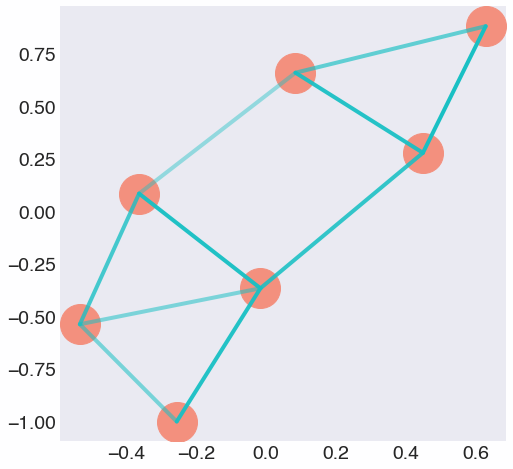

In [117]:
points=getPosFromB1(B1)
plt.figure(figsize=(8,8))
#plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o', color=colors[4], markersize=40)

for i in range(edges.shape[0]):
    plt.plot(points[edges[i].astype(int), 0], points[edges[i].astype(int), 1], color=colors[3], alpha=np.sqrt(w[i]))
plt.grid(False)

([], [])

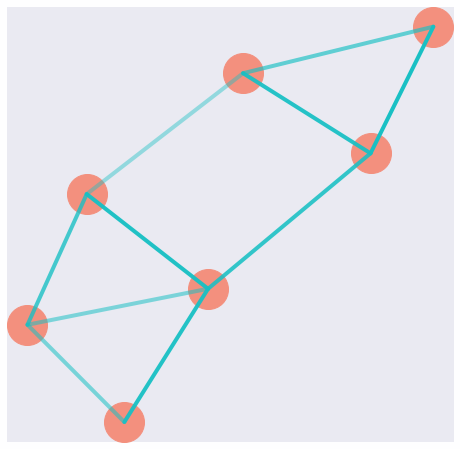

In [118]:
plt.figure(figsize=(8,8))
plt.plot(points[:,0], points[:,1], 'o', color=colors[4], markersize=40)

for i in range(edges.shape[0]):
    plt.plot(points[edges[i].astype(int), 0], points[edges[i].astype(int), 1], color=colors[3], alpha=np.sqrt(w[i]))
plt.grid(False)
plt.xticks([], [])
plt.yticks([], [])

In [119]:
def simpleDrawB1(B1, w, points, eps=0, e=0):
    
    plt.figure(figsize=(8,8))
    plt.plot(points[:,0], points[:,1], 'o', color=colors[4], markersize=40)
    for i in range(points.shape[0]):
        plt.annotate(str(i), (points[i,0], points[i,1]))
    for i in range(edges.shape[0]):
        plt.plot(points[edges[i].astype(int), 0], points[edges[i].astype(int), 1], color=colors[3], linewidth=8*((np.sqrt(w)+eps*e)**2)[i])
    plt.grid(False)
    plt.xticks([], [])
    plt.yticks([], [])

In [120]:
np.ones(w_t.shape[0]).reshape(-1, 1)

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [231]:
def getDt(B2, W):
    w_t=np.diag(W).reshape(-1, 1)
    ones=np.ones(B2.shape[1]).reshape(-1, 1)
    tmp=np.multiply(ones.dot(w_t.T), np.abs(B2).T)
    minval = np.min(tmp[np.nonzero(tmp)].reshape(3, B2.shape[1]), axis=1)
    return np.diag(minval)

In [232]:
def HodgeLW_fr(B1, B2, w, e=0, eps=0):
    W=np.diag(np.sqrt(w)+eps*e)
    Dt=getDt(B2, W)
    L1=W.dot(B1.T.dot(B1.dot(W)))+inv(W).dot(B2.dot(Dt.dot(Dt.dot(B2.T)).dot(inv(W))))
    return L1

In [233]:
L1=HodgeLW_fr(B1, B2, w)
L1

array([[ 3.  ,  2.  , -2.  , -1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ],
       [ 2.  ,  3.  ,  0.  ,  0.  , -1.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ],
       [-2.  ,  0.  ,  3.  ,  1.  , -1.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ],
       [-1.  ,  0.  ,  1.  ,  2.  ,  0.  , -1.  , -1.  ,  0.  ,  0.  ,
         0.  ],
       [ 0.  , -1.  , -1.  ,  0.  ,  2.  ,  1.  ,  0.  , -0.5 , -1.  ,
         0.  ],
       [ 0.  ,  0.  ,  0.  , -1.  ,  1.  ,  2.25,  1.25, -1.  , -1.  ,
         0.  ],
       [ 0.  ,  0.  ,  0.  , -1.  ,  0.  ,  1.25,  2.25,  0.  ,  0.  ,
        -1.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  , -0.5 , -1.  ,  0.  ,  2.5 ,  1.  ,
        -1.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  , -1.  , -1.  ,  0.  ,  1.  ,  2.25,
         0.75],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , -1.  , -1.  ,  0.75,
         2.25]])

$$
F(L_1(W))=\sum_{i=1}^{k+1} \lambda_i^2=\sum_{i=1}^{k+1} (x_i^T L_1 x_i)^2
$$

In [234]:
def getL1k(L1, thr=1e-8):
    return np.sum(np.abs(np.linalg.eig(L1)[0])<thr)

In [235]:
k=getL1k(L1)
k

1

In [236]:
def getFk_l2(L1, k, thr=1e-8):
    #k=getL1k(L1, thr=thr)
    vals, vecs=np.linalg.eig(L1)
    idx = vals.argsort() 
    vals = vals[idx]
    
    return np.sqrt(np.sum(np.power(vals[:k+1], 2)))

In [237]:
getFk_l2(L1, 1)

0.12832207831010503

In [238]:
eps=0.5
e=np.random.uniform(size=w.shape[0])
e=e/np.linalg.norm(e)

In [239]:
def Sym(A):
    return 0.5*(A+A.T)

In [240]:
M=np.zeros((2, 2))
iss=np.array([0, 1])
jss=np.array([1, 0])
M[iss, jss]=1
M

array([[0., 1.],
       [1., 0.]])

In [241]:
M=np.zeros(B2.T.shape )
w_t=w.reshape(-1, 1)
ones=np.ones(B2.shape[1]).reshape(-1, 1)
tmp=np.multiply(ones.dot(w_t.T), np.abs(B2).T)
tmp[tmp==0]=2*np.max(w_t)
ind=np.argmax(-tmp, axis=1)
#M[list(zip(np.arange(0,M.shape[0],1), ind))]=1
M[np.arange(0,M.shape[0],1), ind]=1
M

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])

In [242]:
L1_E=HodgeLW_fr(B1, B2, w, e, eps)
vals, vecs=np.linalg.eig(L1_E)
idx = vals.argsort()
vals = vals[idx]
vecs = vecs[:,idx]

def getG_i(i, B1, B2, L1_E, vecs, w, e, eps):
    W=np.diag(np.sqrt(w)+eps*e)
    x=vecs[:, i].reshape(-1, 1)
    Dt=getDt(B2, W)
    P1=inv(W).dot(B2.dot(Dt.dot(B2.T.dot(inv(W)))))
    w_t=np.diag(W).reshape(-1, 1)
    ones=np.ones(B2.shape[1]).reshape(-1, 1)
    tmp=np.multiply(ones.dot(w_t.T), np.abs(B2).T)
    M=np.zeros(B2.T.shape )
    tmp[tmp==0]=2*np.max(w_t)
    ind=np.argmax(-tmp, axis=1)
    M[np.arange(0,M.shape[0],1), ind]=1
    Add=np.diag(np.diag(B2.T.dot(inv(W).dot(x.dot(x.T.dot(inv(W).dot(B2.dot(Dt))))))).T.dot(M))
    Gi=2.*Sym(x.dot(x.T.dot(W.dot(B1.T.dot(B1))))+ inv(W).dot(x.dot(x.T.dot(P1))))+2.*Add
    return x.T.dot(L1_E.dot(x))*Gi

In [243]:
getG_i(0, B1, B2, L1_E, vecs, w, e, eps)

array([[ 1.32307303e-31, -2.32229194e-32, -7.34969878e-32,
         1.90662620e-32,  2.39591179e-32,  1.29663905e-31,
         5.22427211e-32, -4.53863383e-32, -7.13193782e-32,
         5.86865940e-32],
       [-2.32229194e-32, -4.22313004e-32,  7.75846686e-32,
         4.60956605e-32, -8.30982668e-32, -5.61135692e-32,
        -3.71958637e-32,  1.08223418e-31,  1.96123520e-32,
        -2.62603333e-32],
       [-7.34969878e-32,  7.75846686e-32, -3.69774094e-32,
        -6.91695009e-32,  7.77843130e-32, -3.79946234e-32,
         2.38965536e-33, -7.75426641e-32,  3.03686632e-32,
        -1.79680049e-32],
       [ 1.90662620e-32,  4.60956605e-32, -6.91695009e-32,
        -4.13032066e-32,  7.18576425e-32,  4.40221339e-32,
         3.10563323e-32, -8.16341975e-32, -1.74383943e-32,
         1.90175554e-32],
       [ 2.39591179e-32, -8.30982668e-32,  7.77843130e-32,
         7.18576425e-32, -1.01816957e-31, -1.55592889e-32,
        -2.69341558e-32,  1.00908449e-31, -9.82715354e-34,
        -4.

In [244]:
def scal(A, B):
    return np.trace(A.T.dot(B))

In [245]:
def getDotE(B1, B2, w, e, eps, k, thr=1e-8):
    mask=(np.abs(w+eps*e)<thr)
    matmask=np.diag(np.logical_not((np.abs(w+eps*e)<1e-8)))
    E=np.diag(e)
    PE=np.multiply(E, matmask)
    
    L1_E=HodgeLW_fr(B1, B2, w, e, eps)
    vals, vecs=np.linalg.eig(L1_E)
    idx = vals.argsort()
    vals = vals[idx]
    vecs = vecs[:,idx]
    #k=np.sum(np.abs(vals)<thr)

    GE=np.zeros(L1_E.shape)
    for i in range(k+1):
        GE+=getG_i(i, B1, B2, L1_E, vecs, w, e, eps)
    
    kappa=scal(-GE, PE)/scal(PE, PE)
    PGE=np.multiply(GE, matmask)
    dE=-PGE-kappa*PE
    return dE

In [246]:
matmask=np.diag(np.logical_not((np.abs(w+eps*e)<1e-8)))

In [351]:
e=np.array([0,0,0,0,0,0,0,0,0,0])
eps=0.5

In [352]:
dE=getDotE(B1, B2, w, e, eps, 1)

<ipython-input-245-ecf6d2cca1ab>:18: RuntimeWarning: invalid value encountered in double_scalars
  kappa=scal(-GE, PE)/scal(PE, PE)


In [353]:
np.diag(dE)

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [354]:
np.sqrt(w)

array([0.94525762, 0.77017247, 0.80693441, 0.55417376, 0.40321134,
       0.30629299, 0.43448495, 0.46378586, 0.44051729, 0.36029959])

In [359]:
eps=0.0
e=np.array([0,0,0,0,0,1,0,0,0,0])
e=np.diag(getDotE(B1, B2, w, e, eps, 1))
#e=np.random.uniform(-1, 0, w.shape[0])
e=e/np.linalg.norm(e)
#e=np.array([0,0,0,0,0,0,0,-1,0,0])
eps=0.46378586

p=0.001
L1_E=HodgeLW_fr(B1, B2, w, e, eps)
track=[getFk_l2(L1_E, 1)]
h=1e-3
t_cur=0
log=[]
ts=[0]
#fl=0

print('time: ', t_cur, ' ||  ', track[-1])

for i in range(20000):
    #h=1e-3
    e0=e

    while True:
        while True:
            e=e0
            dE=getDotE(B1, B2, w, e, eps, 1)
            E1=np.diag(e)+h*dE
            e=np.diag(E1)
            if np.sum(np.sqrt(w)+eps*e<0)>0:
                h=h/2
                #print('ups')
            else:
                break
        L1_E=HodgeLW_fr(B1, B2, w, e, eps)
        #if not(fl):
        #    pass
        #else:
        #    fl=0
        #    break
        if getFk_l2(L1_E, 1)>track[-1]:
            h=h/2
        else:
            h=h*2
            break
    L1_E=HodgeLW_fr(B1, B2, w, e, eps)
    log.append(np.sort(np.linalg.eig(L1_E)[0]))
    track.append(getFk_l2(L1_E, 1))
    dE=getDotE(B1, B2, w, e, eps, 1)
    
    if i % 10000 ==0:
        print('time: ', t_cur, ' ||   E_norm:', scal(E1, E1), ',    dE-orth:', scal(dE, E1), track[-1])
    t_cur+=h
    ts.append(t_cur)
   
    #if np.std(track[-50:])/track[-1]<0.01:
        #print('!')
    #    h=1e-3
    #    fl=1

time:  0  ||   0.02660952759388916


KeyboardInterrupt: 

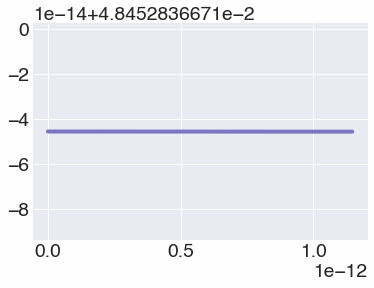

In [346]:
plt.plot(ts[:], track)

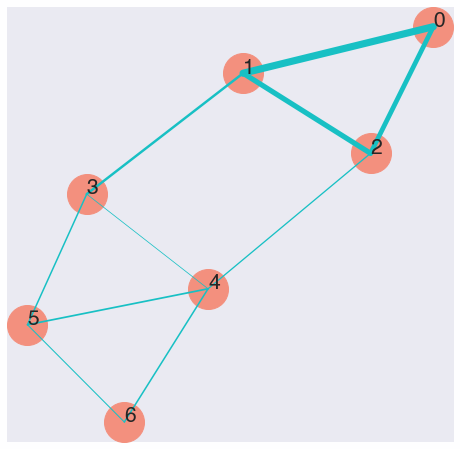

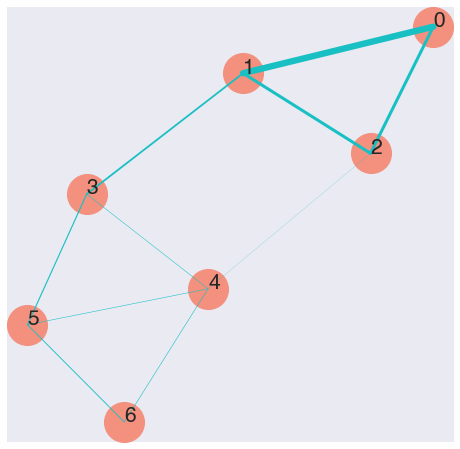

In [329]:
simpleDrawB1(B1, w, points, e=0, eps=0)
simpleDrawB1(B1, w, points, e, eps)

In [322]:
np.sqrt(w)+eps*e, np.sqrt(w)

(array([0.94440744, 0.76979008, 0.80483671, 0.54915828, 0.31949669,
        0.3467475 , 0.43535501, 0.08005244, 0.40744752, 0.11930146]),
 array([0.94525762, 0.77017247, 0.80693441, 0.55417376, 0.40321134,
        0.30629299, 0.43448495, 0.46378586, 0.44051729, 0.36029959]))

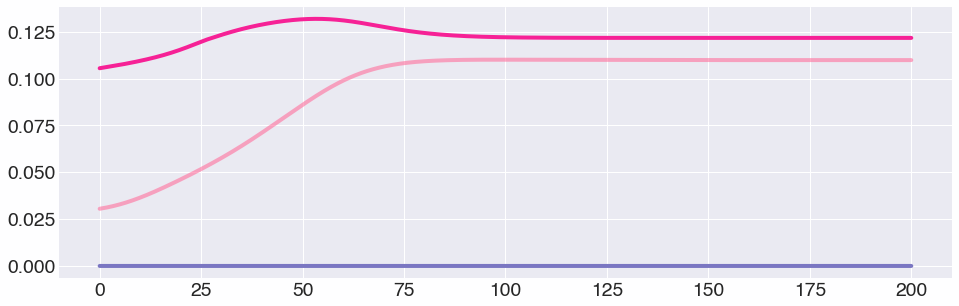

In [323]:
log=np.array(log)

plt.figure(figsize=(16, 5))
plt.plot(ts[1:], log[:, :3])

In [324]:
getL1k(L1_E)
np.linalg.eig(L1_E)[0]

array([4.75532576e+00, 2.34862494e+00, 1.99827365e+00, 8.18010833e-01,
       4.74781562e-01, 3.71362075e-01, 9.67476580e-17, 2.21759919e-01,
       1.21764007e-01, 1.09903604e-01])

In [335]:
points=getPosFromB1(B1)


In [336]:
def simpleDrawB1(B1, w, points, eps=0, e=0):
    
    plt.figure(figsize=(8,8))
    plt.plot(points[:,0], points[:,1], 'o', color=colors[4], markersize=40)
    for i in range(points.shape[0]):
        plt.annotate(str(i), (points[i,0], points[i,1]))
    for i in range(edges.shape[0]):
        plt.plot(points[edges[i].astype(int), 0], points[edges[i].astype(int), 1], color=colors[3], linewidth=8*((np.sqrt(w)+eps*e)**2)[i])
    plt.grid(False)
    plt.xticks([], [])
    plt.yticks([], [])

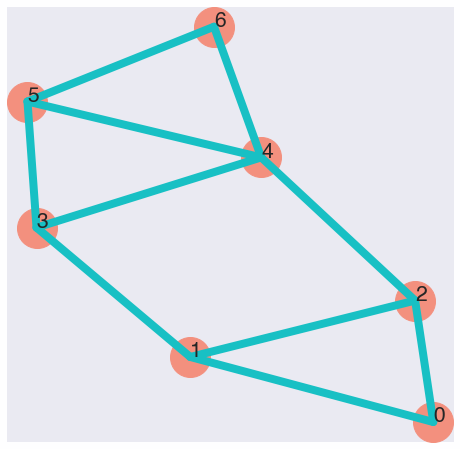

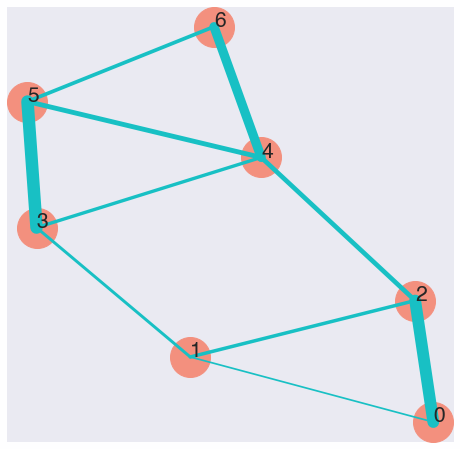

In [337]:
simpleDrawB1(B1, w, points, e=0, eps=0)
simpleDrawB1(B1, w, points, e, eps)

In [289]:
epses=np.hstack([[0.1, 0.2, 0.3, 0.4, 0.5, 0.6], np.arange(0.7, 0.71 , 0.001), [0.8]])
ans=[]
for eps in epses:
    #e=np.random.uniform(size=w.shape[0])
    #e=e/np.linalg.norm(e)
    e=np.array([1, 0, 0, 0, 0, 0, 0, 0,0,0])
    track=[]
    h=1e-3
    t_cur=0
    for i in range(10000):
        h=1e-3
        e0=e
        while True:
            e=e0
            dE=getDotE(B1, B2, w, e, eps, 1)
            E1=np.diag(e)+h*dE
            e=np.diag(E1)
            if np.sum(np.sqrt(w)+eps*e<0)>0:
                h=h/2
            else:
                break
        L1_E=HodgeLW_fr(B1, B2, w, e, eps)
        track.append(sqrt(getFk_l2(L1_E, 1)[0]))
        #track.append(np.sum((np.sort(np.linalg.eig(L1_E)[0])[:2])**2))
        dE=getDotE(B1, B2, w, e, eps, 1)
    ans.append(track[-1])
    #print(np.linalg.eig(L1_E)[0], )

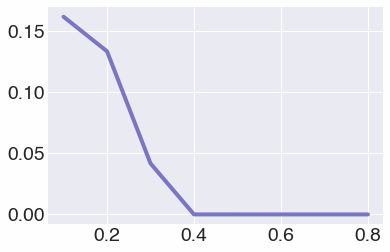

In [290]:
plt.plot(epses, ans)

In [291]:
ans[-1]

1.0200135035568666e-14

In [292]:
np.sqrt(w)+eps*e

array([1.72778562, 0.99595533, 0.99602147, 0.99906208, 0.96771224,
       0.97411972, 0.85596354, 0.82389728, 0.88421906, 1.20857357])

In [293]:
np.sqrt(w)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [294]:
L1_E=HodgeLW_fr(B1, B2, w, e, eps)
np.linalg.eig(L1_E)[0]

array([ 1.49341927e+01,  6.35631788e+00,  4.18733472e+00,  3.73140754e+00,
        2.88601596e+00,  1.58343674e+00,  7.35875640e-01,  5.62488979e-01,
       -2.00194551e-16,  1.01981703e-14])

In [138]:
e

array([-0.45607085, -0.0768569 , -0.55914511, -0.01766808, -0.67698268,
       -0.10954792, -0.00504902, -0.03991747, -0.03380901, -0.00829102])

In [137]:
T=np.abs(B2)


array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [145]:
np.array([1, 1, 1]).reshape(-1, 1).dot(e.reshape(-1, 1))

ValueError: shapes (3,1) and (10,1) not aligned: 1 (dim 1) != 10 (dim 0)

In [151]:
et=e.reshape(-1, 1)

In [156]:
et.dot(np.array([1, 1, 1]).reshape(-1, 1).T)

array([[-0.45607085, -0.45607085, -0.45607085],
       [-0.0768569 , -0.0768569 , -0.0768569 ],
       [-0.55914511, -0.55914511, -0.55914511],
       [-0.01766808, -0.01766808, -0.01766808],
       [-0.67698268, -0.67698268, -0.67698268],
       [-0.10954792, -0.10954792, -0.10954792],
       [-0.00504902, -0.00504902, -0.00504902],
       [-0.03991747, -0.03991747, -0.03991747],
       [-0.03380901, -0.03380901, -0.03380901],
       [-0.00829102, -0.00829102, -0.00829102]])

In [155]:
np.array([1, 1, 1]).reshape(-1, 1).T

array([[1, 1, 1]])

In [158]:
np.multiply((np.array([1, 1, 1]).reshape(-1, 1).dot(et.T)), T.T)

array([[-0.45607085, -0.0768569 , -0.55914511, -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.10954792, -0.00504902, -0.03991747, -0.        , -0.        ],
       [-0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.03991747, -0.03380901, -0.00829102]])

In [171]:
t=np.array([1e-6, 1e-7])
p=-10
np.mean(np.power(t, p))**(1/p)

1.0717734625255745e-07